### This script makes example transition network plots

#### Use the transition csv made in build_dataset.ipynb

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_rgba
from matplotlib.patches import FancyArrowPatch, Circle
from matplotlib.lines import Line2D
import networkx as nx
import numpy as np
import os
import pandas as pd

In [4]:
# Set the working directory 
path_to_csvs = r"C:\Users\irs3th\keypoint-moseq\home_cage\results"  
if not os.path.exists(path_to_csvs):
    raise FileNotFoundError(f"Cannot find the path: '{path_to_csvs}'")

# Verify
os.chdir(path_to_csvs)
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\irs3th\keypoint-moseq\home_cage\results


In [5]:
# Read csv from build_dataset
transition_df = pd.read_csv('normalized_transitions_v4.csv') # toy

In [6]:
# Filter for groups we want to plot
groups_to_keep = ['dan_sd', 'lira_sd', 'orfo', 'LiCl', 'fed', 'veh_sd']

transition_df = transition_df[transition_df['group'].isin(groups_to_keep)]


In [7]:
# collect all transition columns (skip id + group)
transition_cols = [c for c in transition_df.columns if c not in ["id", "group"]]

pairs = {}
for col in transition_cols:
    src, dst = col.split("_", 1)  # split only on first underscore
    reverse = f"{dst}_{src}"
    if reverse in transition_cols:
        # build a standardized name (alphabetical to avoid duplicates)
        merged_name = "_".join(sorted([src, dst]))
        pairs.setdefault(merged_name, set()).update([col, reverse])
    else:
        # transitions without a reverse pair stay as is
        pairs[col] = {col}

# now combine
for merged_name, cols in pairs.items():
    transition_df[merged_name] = transition_df[list(cols)].sum(axis=1)

# drop the old directed columns
transition_df = transition_df[["id", "group"] + list(pairs.keys())]

#print(transition_df.head())


In [8]:
# Average normalized probability by group
avg_transition_matrix = transition_df.groupby('group').mean(numeric_only=True)
filtered = avg_transition_matrix.drop('id', axis=1) # averaged by accident above

#filtered.head()

## Directed plot (directionality with arrows)
### You can curve arrows so they don't overlap or save as eps and modify in Illustrator

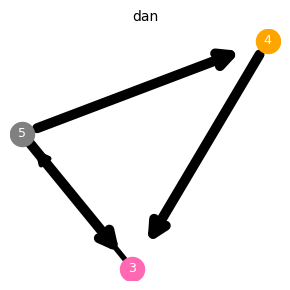

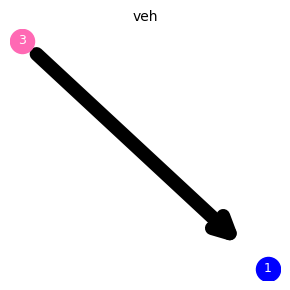

In [8]:
# Outline
filtered = avg_transition_matrix
min_edge_weight = 0.01 # Change as you want
max_arrow_width = 10 # Change as you want
plot_size = (3, 3) # Change as you want
output_dir = "network_eps_exports"
os.makedirs(output_dir, exist_ok=True)

# Node colors
node_colors = {
    'food motivated': 'blue',
    'drink': 'green',
    'move/explore': 'hotpink',
    'groom': 'orange',
    'rest/groom in shelter': 'grey'
    }

# Mappings
behavior_numbering = {b: i+1 for i, b in enumerate(node_colors)}
number_to_behavior = {v: k for k, v in behavior_numbering.items()}

# Global max weight for normalization (I use the overall max to weight individual groups)
global_max_weight = max(
    float(val)
    for _, row in filtered.iterrows()
    for col, val in row.items()
    if isinstance(val, (int, float)) and val > 0
)

# Plotting
for index, row in filtered.iterrows():
    group = index
    G = nx.DiGraph()

    for col, val in row.items():
        try:
            source, target = col.rsplit('_', 1)
            if source in behavior_numbering and target in behavior_numbering:
                weight = float(val)
                norm_weight = weight / global_max_weight
                if norm_weight >= min_edge_weight:
                    G.add_edge(behavior_numbering[source], behavior_numbering[target], weight=norm_weight)
        except:
            continue

    if G.number_of_edges() == 0:
        continue

    pos = nx.spring_layout(G, seed=42, k=0.4)
    fig, ax = plt.subplots(figsize=plot_size)

    # Draw nodes
    for node, (x, y) in pos.items():
        behavior = number_to_behavior[node]
        ax.scatter(x, y, s=300, color=node_colors[behavior], zorder=3) # Z order for visuals (node on top of arrows)
        ax.text(x, y, str(node), color='white', fontsize=9, ha='center', va='center', zorder=4)

    # Draw straight arrows
    for u, v, d in G.edges(data=True):
        if u == v:
            continue

        x1, y1 = pos[u]
        x2, y2 = pos[v]
        dx, dy = x2 - x1, y2 - y1

        # Offset endpoints a bit
        x1_adj = x1 + dx * 0.05
        y1_adj = y1 + dy * 0.05
        x2_adj = x2 - dx * 0.1
        y2_adj = y2 - dy * 0.1

        edge_width = min(0.5 + d['weight'] * max_arrow_width, max_arrow_width) # Scale

        arrow = FancyArrowPatch(
            (x1_adj, y1_adj), (x2_adj, y2_adj),
            arrowstyle='->',
            mutation_scale=10 + edge_width * 2,
            color='black',
            linewidth=edge_width, 
            zorder=1
        )
        ax.add_patch(arrow)

    ax.set_title(f"{group}", fontsize=10)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Save 
    filename = os.path.join(output_dir, f"{group.replace('/', '_')}.png")
    #plt.savefig(filename, format='eps', dpi=600)
    plt.close()

### Aesthetic updates
#### - scaled colors for edges
#### - double arrowheads
#### - more space between nodes and edges

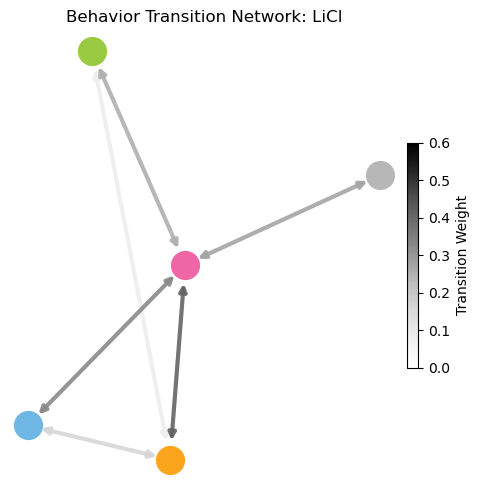

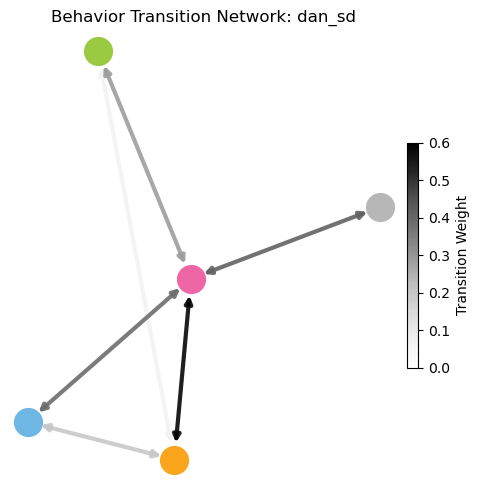

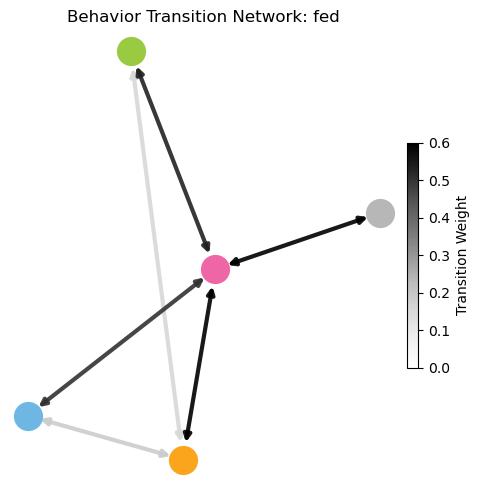

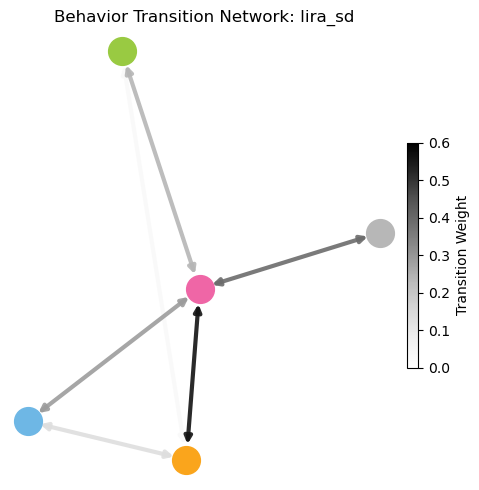

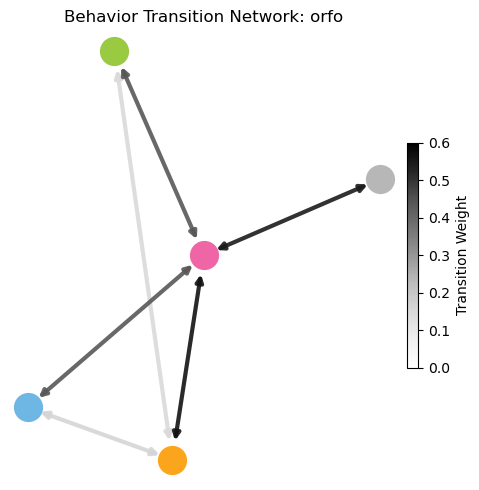

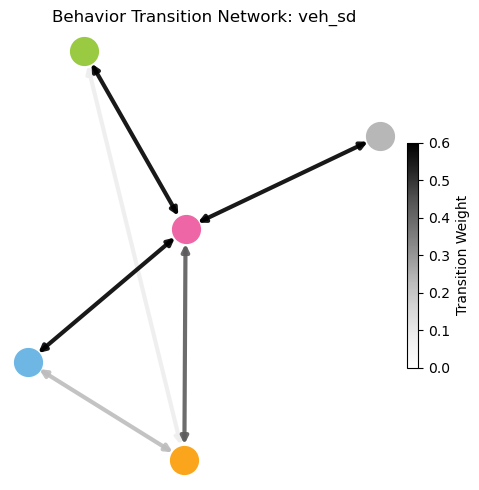

In [10]:
# Node colors
node_colors = {
    'food motivated': '#6EB7E5',
    'drink': '#99CA42',
    'move/explore': '#EF66A6',
    'groom': '#FAA51C',
    'shelter': '#B7B7B7'
}

behavior_numbering = {behavior: i + 1 for i, behavior in enumerate(node_colors)}
number_to_behavior = {v: k for k, v in behavior_numbering.items()}

# Calculate global max weight for scaling edges
global_max_weight = filtered.max().max()

# Grayscale colormap for edges
cmap = cm.Greys

for group, row in filtered.iterrows():
    G = nx.Graph()  # undirected

    # Add edges with raw weights
    for col, value in row.items():
        try:
            val = float(value)
            if val > 0:
                source, target = col.rsplit('_', 1)
                if source in behavior_numbering and target in behavior_numbering:
                    G.add_edge(
                        behavior_numbering[source],
                        behavior_numbering[target],
                        weight=val
                    )
        except Exception:
            continue

    # Layout (increase `k` to spread nodes apart more)
    pos = nx.spring_layout(G, seed=42, k=1, weight="weight")

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    # Draw nodes
    for node, (x, y) in pos.items():
        ax.scatter(x, y, s=400, color=node_colors[number_to_behavior[node]], zorder=3)
       # ax.text(x, y, str(node), color="white", fontsize=10,
                #ha="center", va="center", zorder=4)

    # Normalize edge colors
    desired_max = 0.6  # adjust as needed
    norm = plt.Normalize(vmin=0, vmax=desired_max)

    node_radius = 0.05  # adjust to push arrows further away from nodes

    # Draw edges with "constant linewidth" but grayscale color
    for u, v, d in G.edges(data=True):
        weight = d["weight"]
        lw = 3  
        color = cmap(norm(weight))

        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Compute vector and shrink it at both ends
        dx, dy = x2 - x1, y2 - y1
        dist = np.sqrt(dx**2 + dy**2)
        if dist > 0:
            offset_x = dx / dist * node_radius
            offset_y = dy / dist * node_radius
            x1_off, y1_off = x1 + offset_x, y1 + offset_y
            x2_off, y2_off = x2 - offset_x, y2 - offset_y
        else:
            x1_off, y1_off, x2_off, y2_off = x1, y1, x2, y2

        # Draw double-headed arrow
        ax.annotate("",
                    xy=(x2_off, y2_off), xycoords="data",
                    xytext=(x1_off, y1_off), textcoords="data",
                    arrowprops=dict(arrowstyle="<|-|>",
                                    color=color,
                                    lw=lw,
                                    alpha=0.9),
                    zorder=2,
                    )

    # Add grayscale colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
    cbar.set_label("Transition Weight", fontsize=10)

    plt.title(f"Behavior Transition Network: {group}")
    plt.axis("off")
    plt.tight_layout()
    filename = os.path.join(path_to_csvs, f"{group.replace('/', '_')}.eps")
    #plt.savefig(filename, format="eps", dpi=600)
    plt.show()
    plt.close()
